# Data-Prep: CRM Data

# Load libs

In [1]:

# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

import pandas as pd
pd.options.display.max_columns = None


## Libraries & Settings ##
from pa_lib.file import load_bin
from pa_lib.util import cap_words
from pa_lib.log import time_log, info

import datetime as dt
from dateutil.relativedelta import relativedelta

from pa_lib.data import (
    clean_up_categoricals,
    unfactorize,
)

from pa_lib.data import desc_col

In [2]:
from pa_lib.data import boxplot_histogram
import numpy as np


# Load CRM data

In [3]:
def load_crm_data():
    raw_data = load_bin("vkprog\\crm_data_vkprog.feather").rename(
        mapper=lambda name: cap_words(name, sep="_"), axis="columns"
    )
    return raw_data.astype({"Year": "int64", "KW_2": "int64"})


In [4]:
raw_crm_data = load_crm_data()

2019-10-08 14:04:15 [INFO] Started loading binary file
2019-10-08 14:04:15 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
2019-10-08 14:04:16 [INFO] Finished loading binary file in 0.39s (0.22s CPU)


In [5]:
#raw_crm_data.eval("YYYYKW_2 = Year * 100 + KW_2", inplace=True)

# View raw crm data

In [6]:
display(raw_crm_data.pivot_table(
    index=["Kanal"],
    columns=["Year"],
    values=["Endkunde_NR"],
    aggfunc="count",
    fill_value=0)
)

Endkunde_NR                                                     \
Year                 2013   2014   2015    2016    2017    2018    2019 2020   
Kanal                                                                          
Besprechung            91    171    179     749     547     213     116    0   
Besuch               2546  10941  11944   12302   11974   10922    7830   51   
Brief                2924   7512   3664    6305    3371    3873    2383    0   
Dankeskarte             0     68     76      82      77      72      44    0   
E-Mail              17177  73949  97372  158107  147074  158915  103440    1   
Event                  54    223     99     674     848     601       0    0   
Fax                     0      1      1       4       5       2       0    0   
Internet               23     85     99     112     127      88      73    0   
SMS                     1      8      6      17      10       8       5    0   
Telefon               970   4942   9424    7388    7644    8117    4577   17   
Twitter                 0      2      0       0       0       0       0    0   
Veranstaltung           0    238    375     200      84     116      68    0   

                                   
Year          2021 2022 2023 2024  
Kanal                              
Besprechung      0    0    0    0  
Besuch           0    0    1    0  
Brief            0    0    0    0  
Dankeskarte      0    0    0    0  
E-Mail           1    1    1    1  
Event            0    0    0    0  
Fax              0    0    0    0  
Internet         0    0    0    0  
SMS              0    0    0    0  
Telefon          0    0    0    0  
Twitter          0    0    0    0  
Veranstaltung    0    0    0    0

# Define Groups

In [7]:
from functools import reduce

all_kanal =set(raw_crm_data.loc[:,"Kanal"])
kanal_grps = {}

kanal_grps["Besprechung"]         = {"Besprechung"}
kanal_grps["Besuch"]              = {"Besuch"}
kanal_grps["Brief_Dankeskarte"]   = {"Brief","Dankeskarte"}
kanal_grps["E-Mail"]              = {"E-Mail"}
kanal_grps["Event_Veranstaltung"] = {"Event","Veranstaltung"}
kanal_grps["Telefon"]             = {"Telefon"}

# Stuff all the rest into "Anderes":
kanal_grps["Anderes"]             =  all_kanal - reduce(set.union,kanal_grps.values())  

# Yearly aggregation per ``Kanal`` group element

In [8]:
def contacts_grouped_yrly(date_view,kanal_grps,year_span):
    ####
    def yrl_kanal_contacts(date_view, group_name, rel_year):
        return (raw_crm_data.loc[(raw_crm_data.loc[:,"Kanal"].isin(kanal_grps[group_name]) &     # adjust to key
                         (raw_crm_data.loc[:,"Datum"] <  date_view  - relativedelta(years= rel_year   )) &
                         (raw_crm_data.loc[:,"Datum"] >= date_view  - relativedelta(years= rel_year+1 )) # adjust years
                         ),:]
                    .groupby("Endkunde_NR").count()
                    .reset_index(inplace=False)
                    .loc[:,["Endkunde_NR","Kanal"]]
                    .rename(columns={"Kanal": f"RY_{rel_year}_Anz_{group_name}"})   # adjust "Anzahl"
                    #.sort_values("Anzahl", ascending=False)
               )
    #####
    container_df = yrl_kanal_contacts(date_view=date_view,
                                      group_name=list(kanal_grps.keys())[1],rel_year=0).loc[:,"Endkunde_NR"]
    for name in kanal_grps.keys():
        for i in range(year_span):
            rel = yrl_kanal_contacts(date_view=date_view,
                                     group_name=name,
                                     rel_year=i)
            container_df = pd.merge(container_df,
                                    rel,
                                    on="Endkunde_NR",
                                    how="inner")
    return container_df

## Delta(view_date, last_contact)

In [12]:
def delta_contact(date_view,kanal_grps):
    for name in kanal_grps.keys():
        raw_crm_data.loc[raw_crm_data.Kanal.isin(kanal_grps[name]), "Kanal_Grps"] = name
    
    max_vertical_df = (raw_crm_data.loc[(raw_crm_data.loc[:,"Datum"] <  date_view) # adjust years
                     ,:]
                .groupby(["Endkunde_NR", "Kanal_Grps"])
                .agg({"Datum": np.max})
                .reset_index(inplace=False)
                   )
    max_vertical_df["delta_days"] = (date_view - max_vertical_df.loc[:,"Datum"]).apply(lambda x: x.total_seconds()) / 86400  # delta in days
    
    flatten_df = max_vertical_df.pivot_table(
        index   = "Endkunde_NR",
        columns = ["Kanal_Grps"],
        values  = ["delta_days"],
        aggfunc = "min").reset_index(inplace=False)
    
    flatten_df  = pd.DataFrame(flatten_df.to_records(index=False))
    flatten_df.columns = ["Endkunde_NR"]+[ "Letzter_Kontakt_Delta_"+x.replace("'","").replace("(","").replace("delta_days, ","").replace(",","").replace(" ","").replace(")","") for x in flatten_df.columns[1:]]
    
    flatten_df["Letzter_Kontakt_Delta_global"] = flatten_df.iloc[:,1:].min(axis = 1, skipna = True)
    
    #Letzte_Buchung_Delta
    
    return flatten_df

# Wrapper Function, that does everything in one go!

In [13]:
def crm_train_scoring(day, month, year_score, year_train, year_span):
    date_now      = dt.datetime(year_score,month,day) # only works for odd calendar weeks!!!
    date_training = dt.datetime(year_train,month,day) # only works for odd calendar weeks!!!
    
    def crm_prep(date_view,year_span):
        last_contacts_df      = delta_contact(date_view=date_view,
                                              kanal_grps=kanal_grps)
        grpd_yrly_contacts_df = contacts_grouped_yrly(date_view=date_view,
                                                      kanal_grps=kanal_grps,
                                                      year_span=year_span)

        return pd.merge(grpd_yrly_contacts_df,last_contacts_df,on="Endkunde_NR",how="inner")
    
    crm_train_df = crm_prep(date_view=date_training, year_span=year_span)
    crm_score_df = crm_prep(date_view=date_now,      year_span=year_span)
    
    return (crm_train_df, crm_score_df)
    
    

# Testing Wrapper-Function

In [14]:
crm_train_df, crm_score_df = crm_train_scoring(day=23,
                                               month=9,
                                               year_score=2019,
                                               year_train=2018,
                                               year_span=4)

In [15]:
crm_train_df.head()

,Endkunde_NR,RY_0_Anz_Besprechung,RY_1_Anz_Besprechung,RY_2_Anz_Besprechung,RY_3_Anz_Besprechung,RY_0_Anz_Besuch,RY_1_Anz_Besuch,RY_2_Anz_Besuch,RY_3_Anz_Besuch,RY_0_Anz_Brief_Dankeskarte,RY_1_Anz_Brief_Dankeskarte,RY_2_Anz_Brief_Dankeskarte,RY_3_Anz_Brief_Dankeskarte,RY_0_Anz_E-Mail,RY_1_Anz_E-Mail,RY_2_Anz_E-Mail,RY_3_Anz_E-Mail,RY_0_Anz_Event_Veranstaltung,RY_1_Anz_Event_Veranstaltung,RY_2_Anz_Event_Veranstaltung,RY_3_Anz_Event_Veranstaltung,RY_0_Anz_Telefon,RY_1_Anz_Telefon,RY_2_Anz_Telefon,RY_3_Anz_Telefon,RY_0_Anz_Anderes,RY_1_Anz_Anderes,RY_2_Anz_Anderes,RY_3_Anz_Anderes,Letzter_Kontakt_Delta_Anderes,Letzter_Kontakt_Delta_Besprechung,Letzter_Kontakt_Delta_Besuch,Letzter_Kontakt_Delta_Brief_Dankeskarte,Letzter_Kontakt_Delta_E-Mail,Letzter_Kontakt_Delta_Event_Veranstaltung,Letzter_Kontakt_Delta_Telefon,Letzter_Kontakt_Delta_global
0,100034,0,0,0,0,0,0,2,5,0,0,1,0,16,6,9,7,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,930.0,972.0,12.0,NaN,NaN,12.0
1,100039,0,0,0,0,1,0,0,0,0,0,0,0,8,9,11,1,0,0,0,0,1,1,0,0,0,0,0,0,NaN,NaN,130.0,NaN,12.0,NaN,306.0,12.0
2,100043,0,0,0,0,0,0,0,0,0,0,0,0,0,5,12,8,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,1705.0,NaN,562.0,NaN,NaN,562.0
3,100045,0,0,0,0,0,1,0,0,1,0,1,0,11,8,9,6,2,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,516.0,164.0,12.0,164.0,387.0,12.0
4,100048,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,374.0,NaN,NaN,374.0


In [16]:
def lazy_bxplt_hstgrm(delta_contacts_df):
    for name in delta_contacts_df.columns[1:]:
        print(name)
        boxplot_histogram(delta_contacts_df.loc[delta_contacts_df.loc[:,name] > 0, name])

In [17]:
desc_col(crm_train_df)


,DTYPE,NULLS,UNIQUE
Endkunde_NR,object,0/45374,45374
RY_0_Anz_Besprechung,int64,0/45374,10
RY_1_Anz_Besprechung,int64,0/45374,19
RY_2_Anz_Besprechung,int64,0/45374,13
RY_3_Anz_Besprechung,int64,0/45374,7
RY_0_Anz_Besuch,int64,0/45374,29
RY_1_Anz_Besuch,int64,0/45374,28
RY_2_Anz_Besuch,int64,0/45374,28
RY_3_Anz_Besuch,int64,0/45374,26
RY_0_Anz_Brief_Dankeskarte,int64,0/45374,8


RY_0_Anz_Besprechung


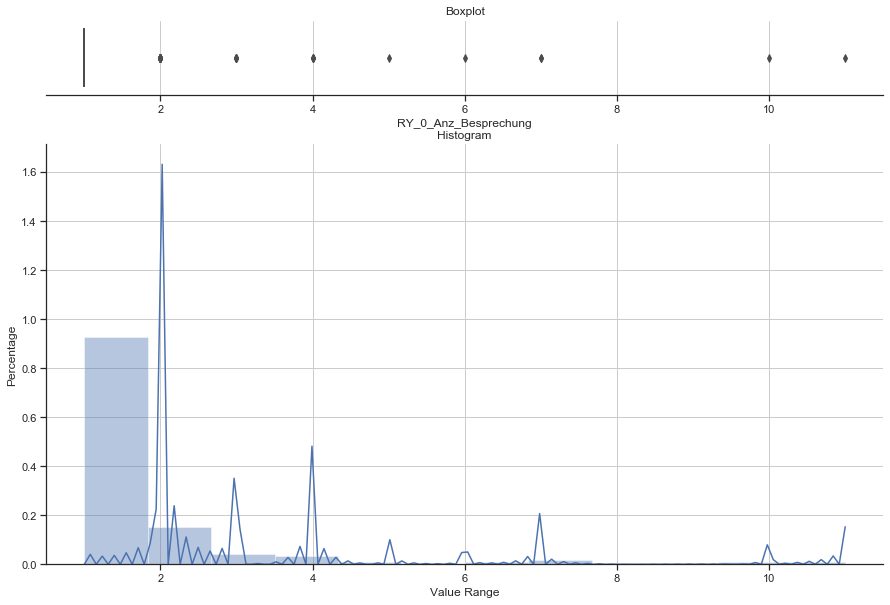

RY_1_Anz_Besprechung


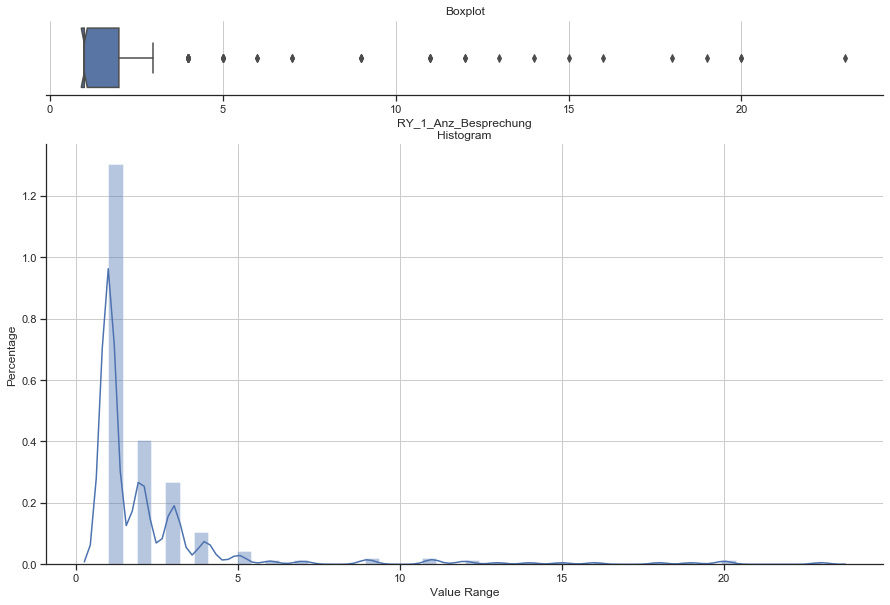

RY_2_Anz_Besprechung


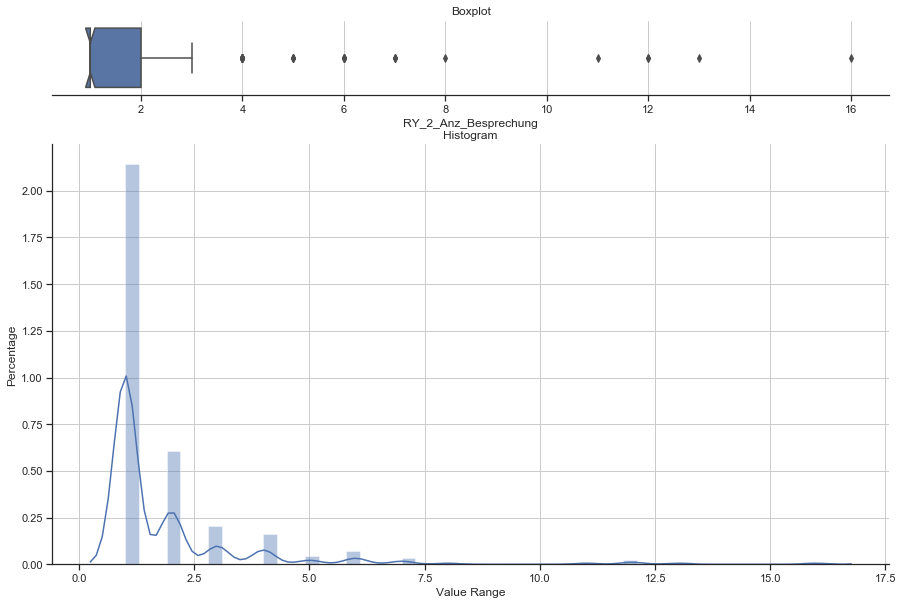

RY_3_Anz_Besprechung


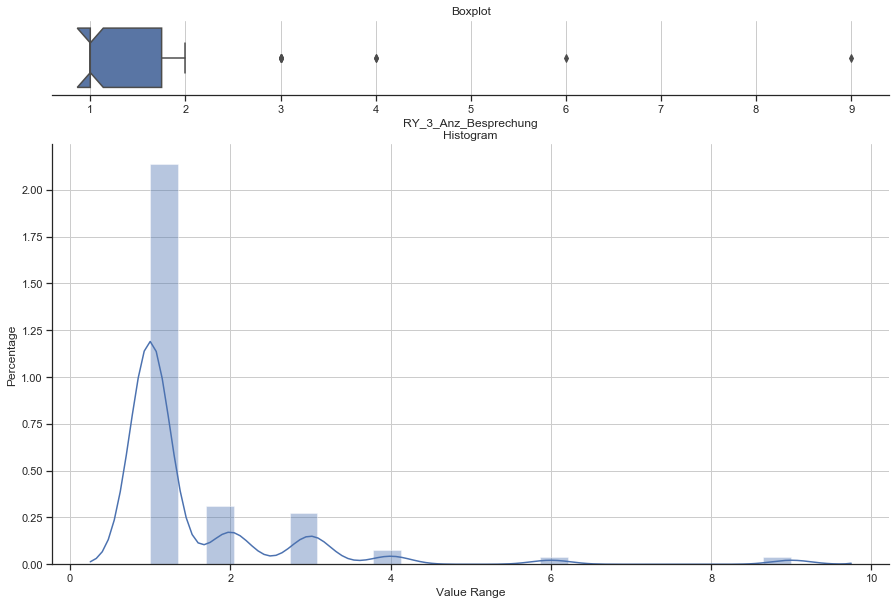

RY_0_Anz_Besuch


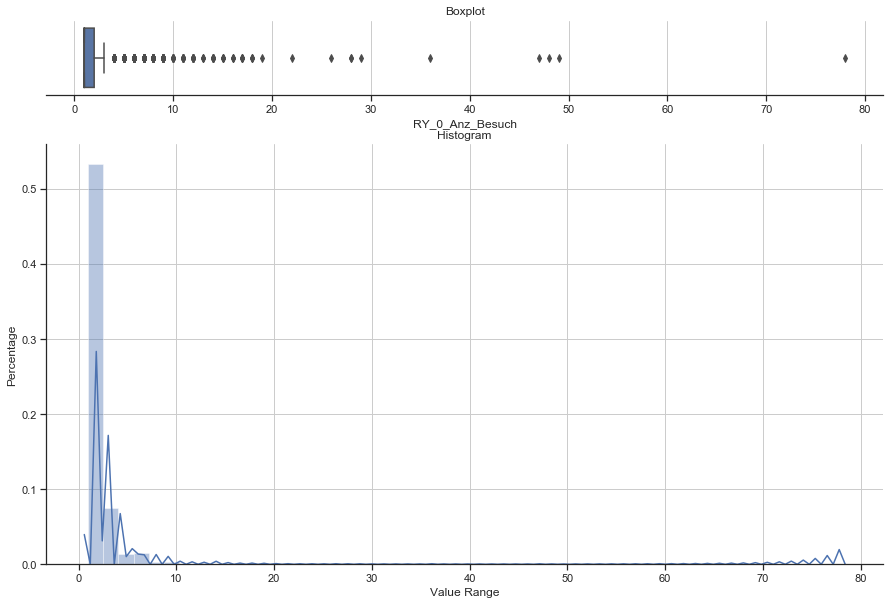

RY_1_Anz_Besuch


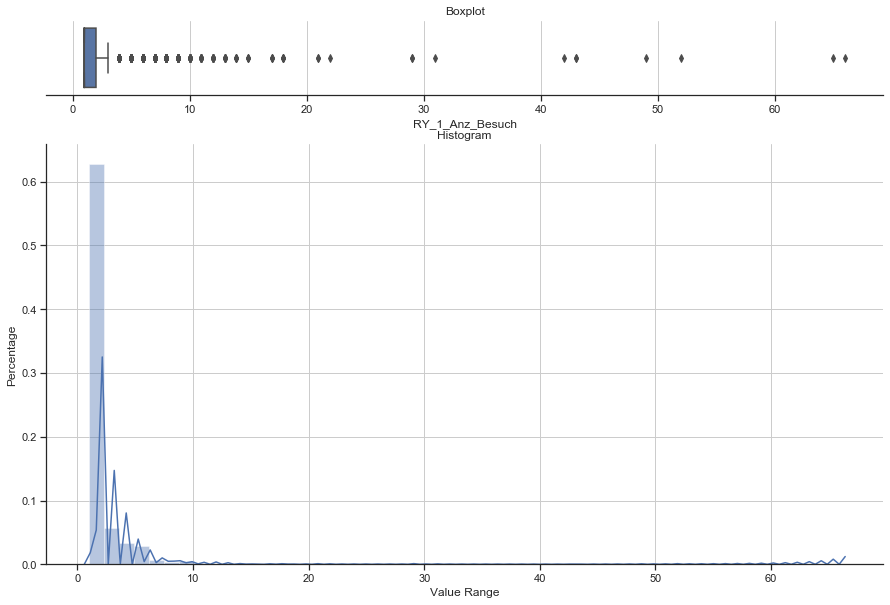

RY_2_Anz_Besuch


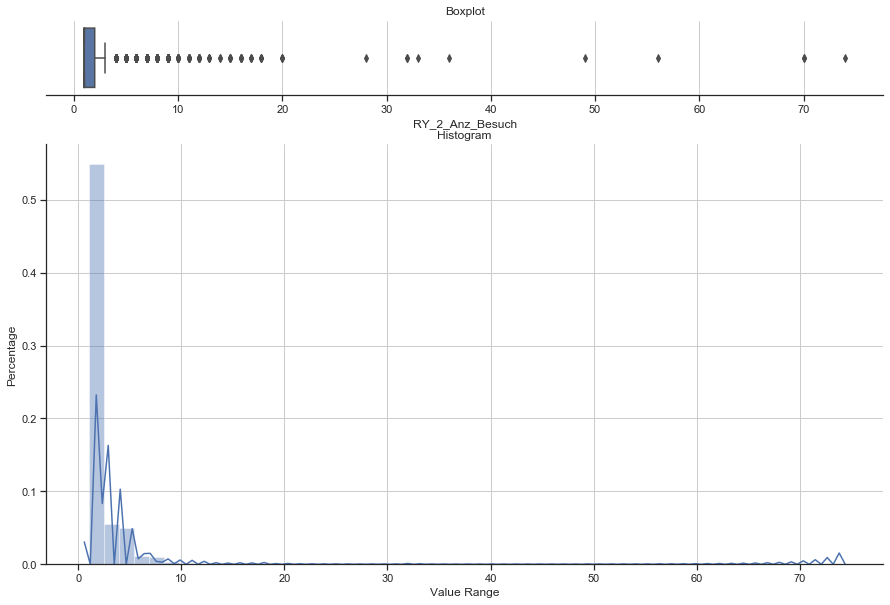

RY_3_Anz_Besuch


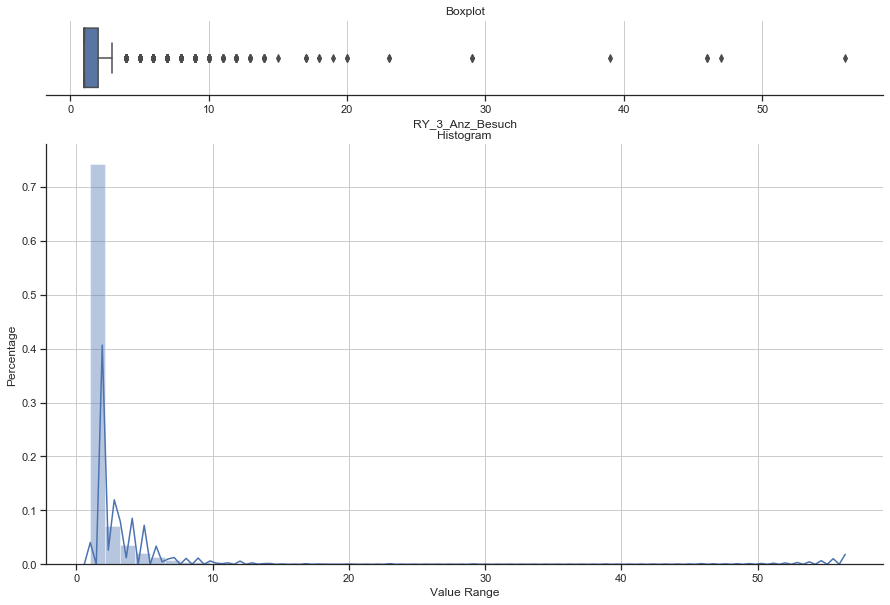

RY_0_Anz_Brief_Dankeskarte


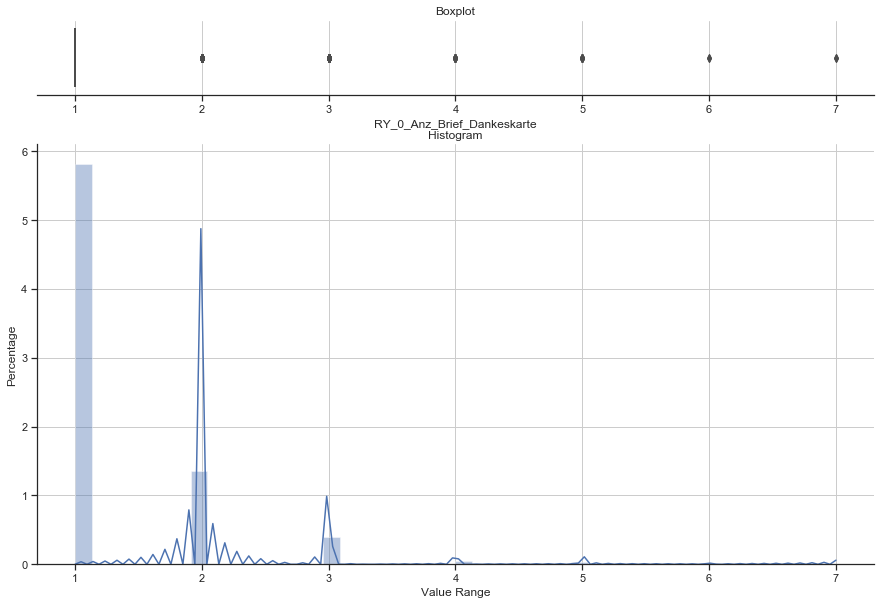

RY_1_Anz_Brief_Dankeskarte


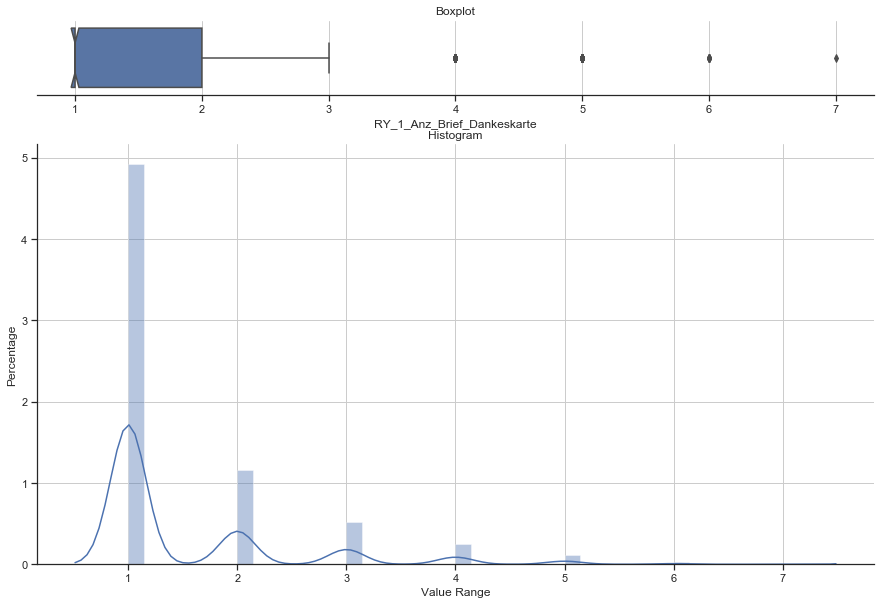

RY_2_Anz_Brief_Dankeskarte


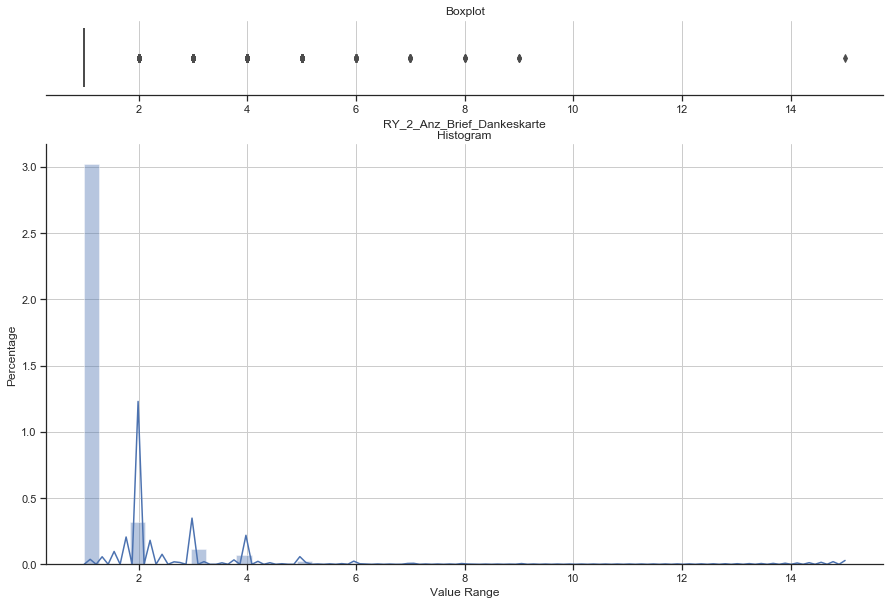

RY_3_Anz_Brief_Dankeskarte


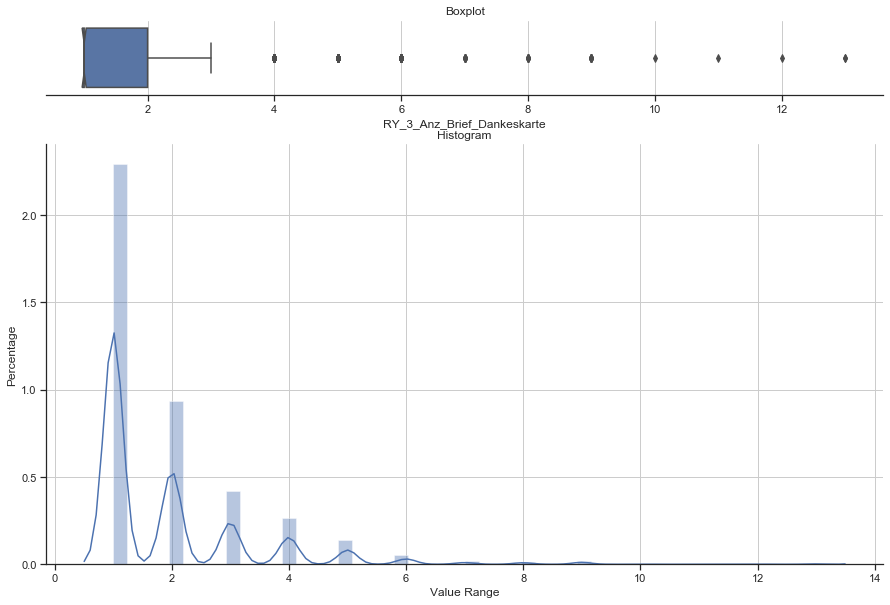

RY_0_Anz_E-Mail


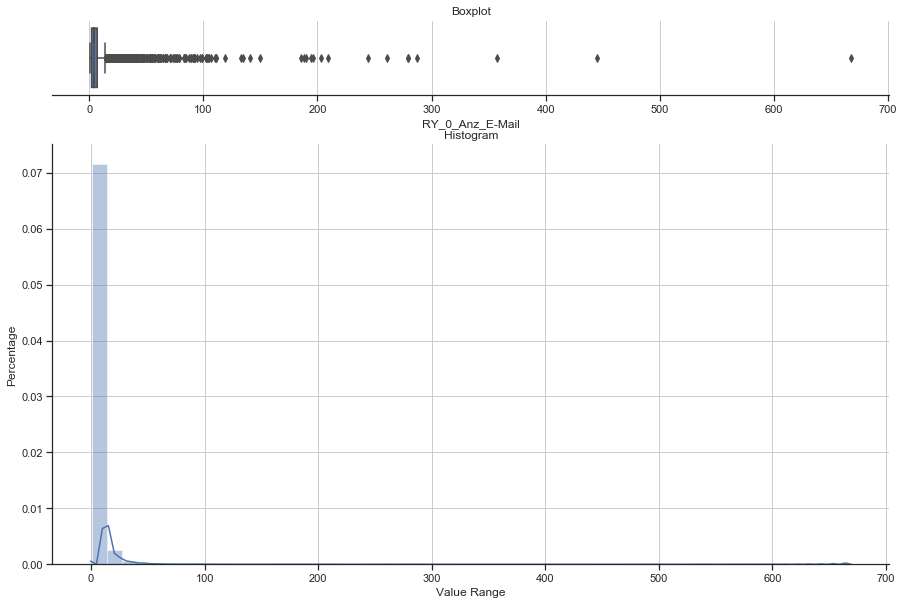

RY_1_Anz_E-Mail


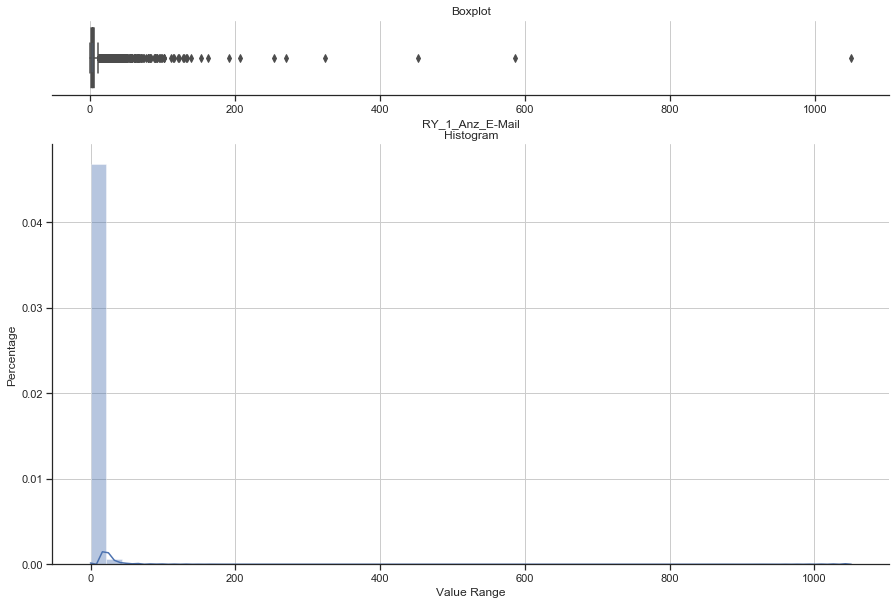

RY_2_Anz_E-Mail


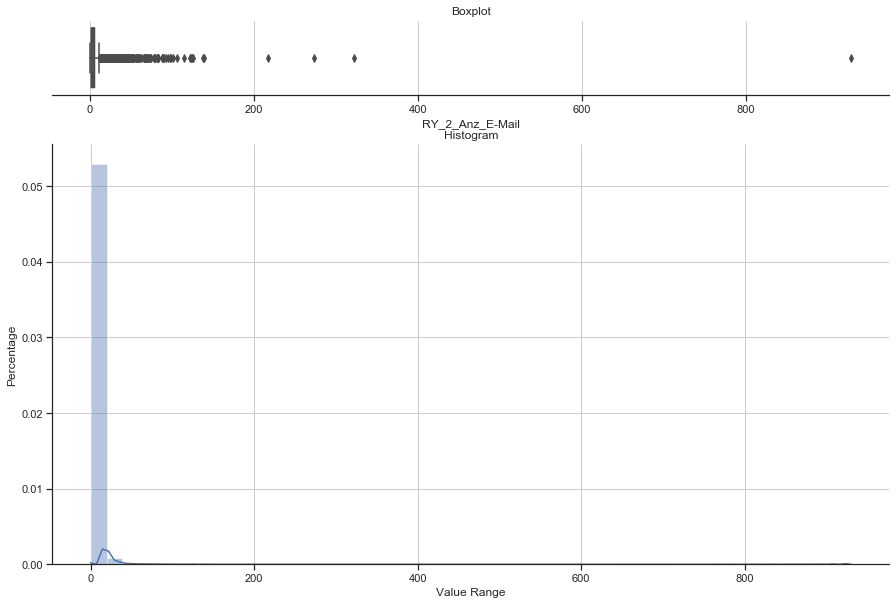

RY_3_Anz_E-Mail


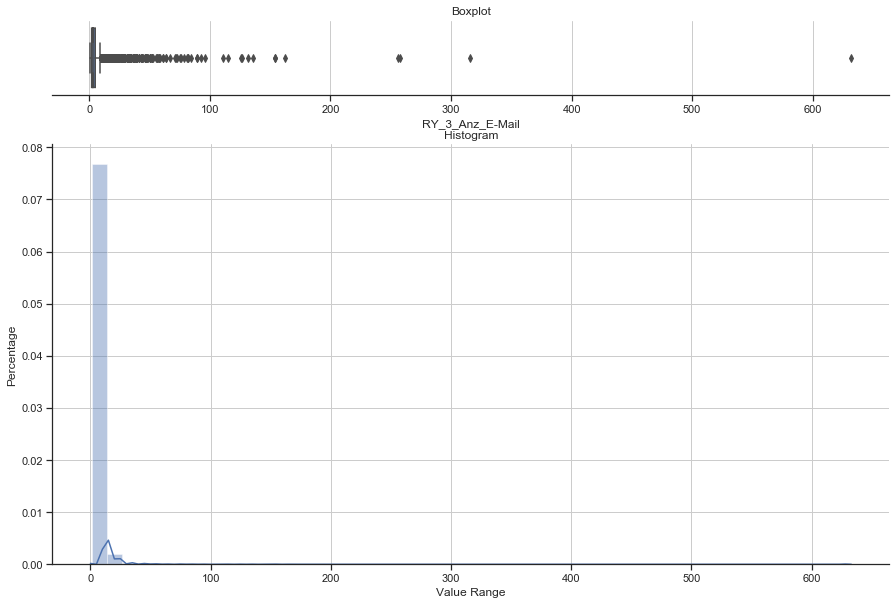

RY_0_Anz_Event_Veranstaltung


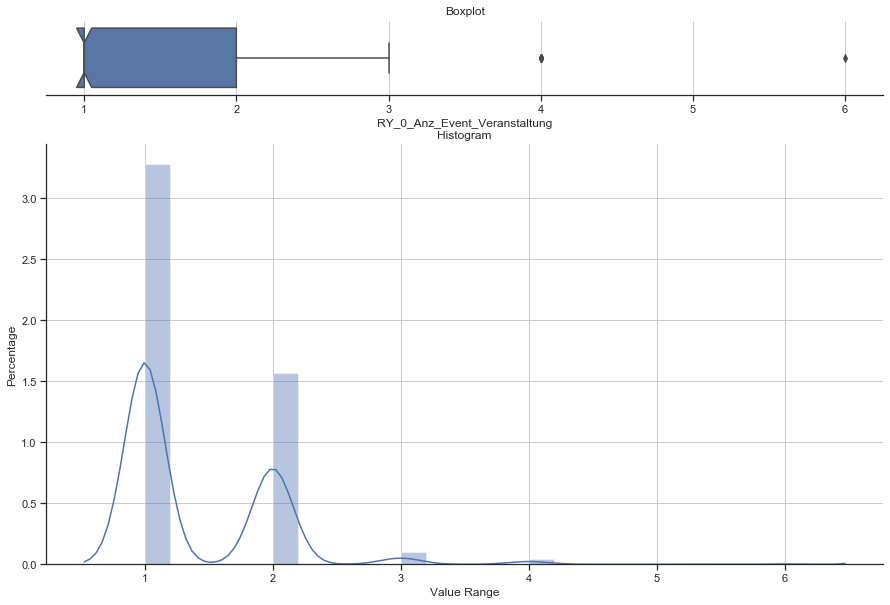

RY_1_Anz_Event_Veranstaltung


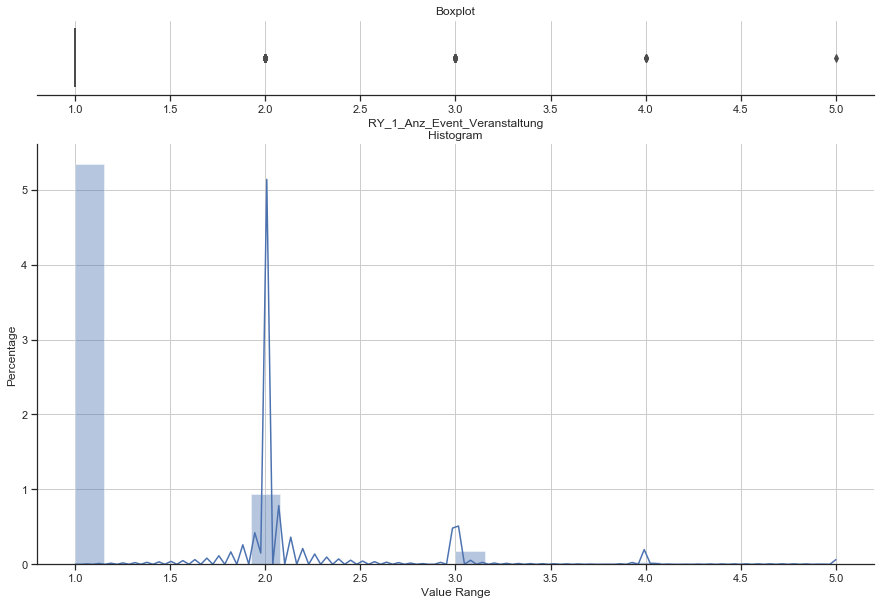

RY_2_Anz_Event_Veranstaltung


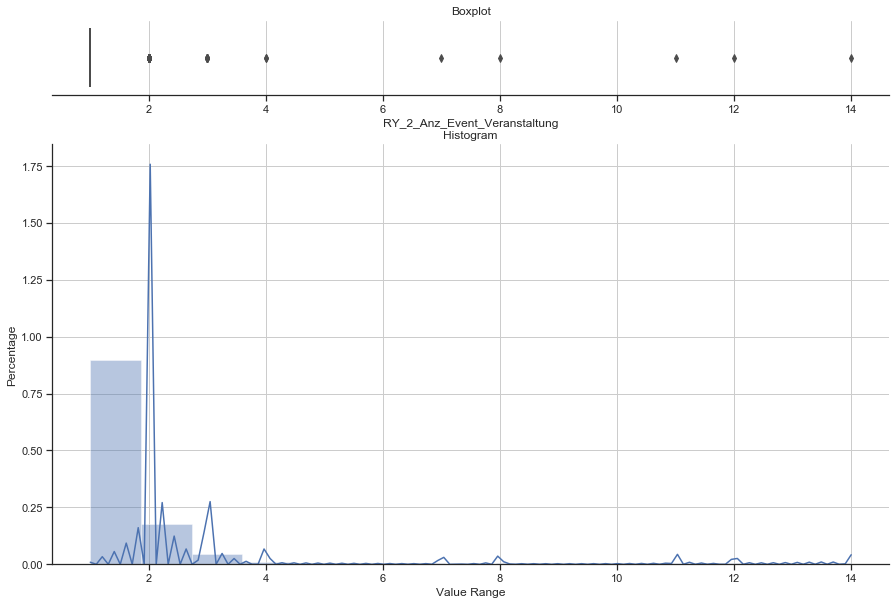

RY_3_Anz_Event_Veranstaltung


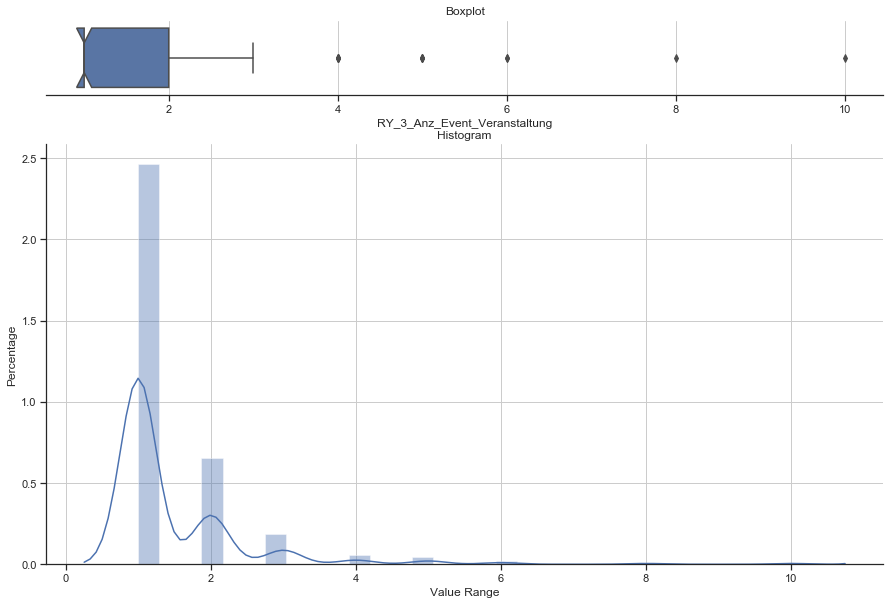

RY_0_Anz_Telefon


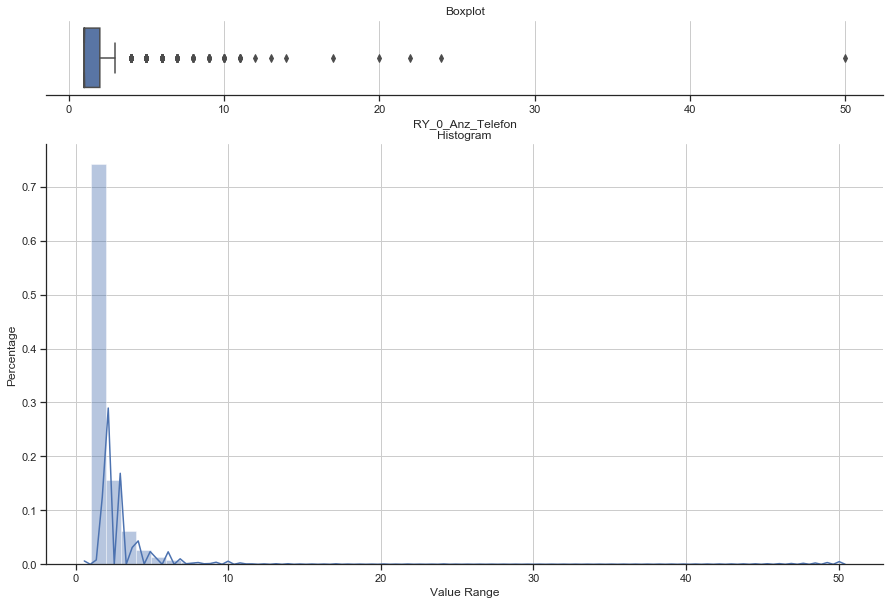

RY_1_Anz_Telefon


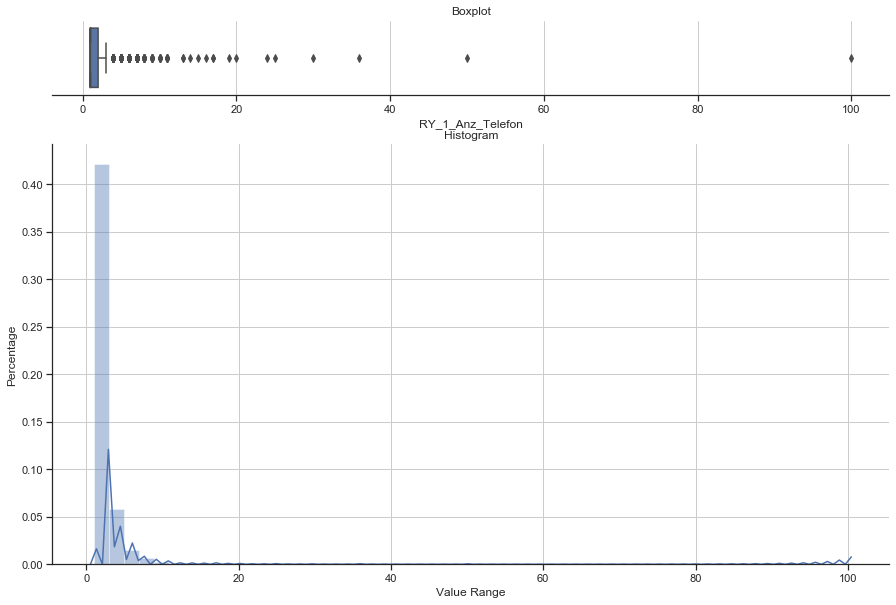

RY_2_Anz_Telefon


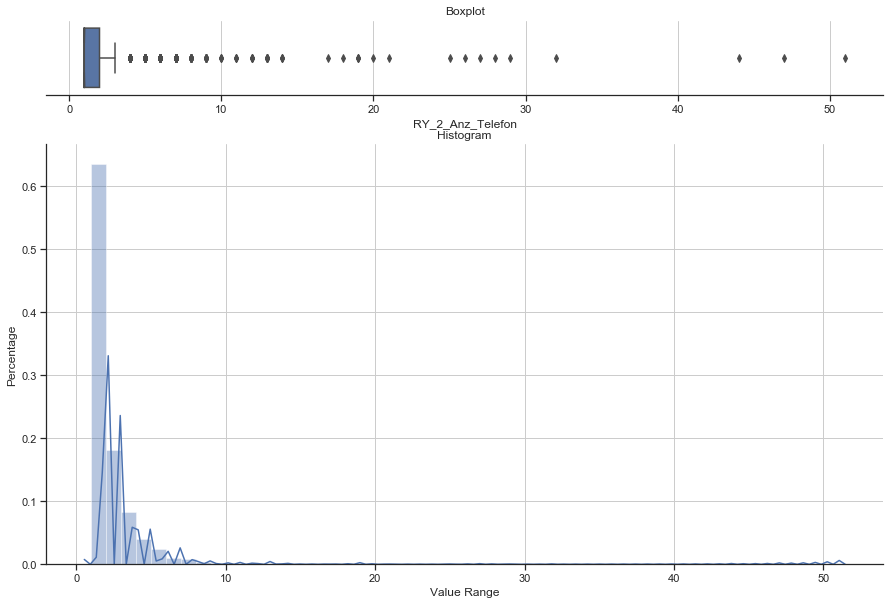

RY_3_Anz_Telefon


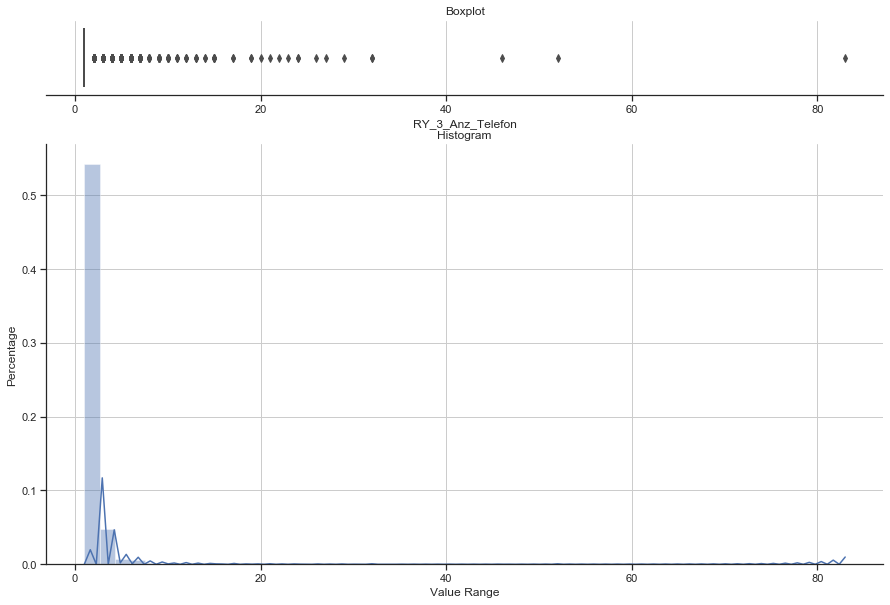

RY_0_Anz_Anderes


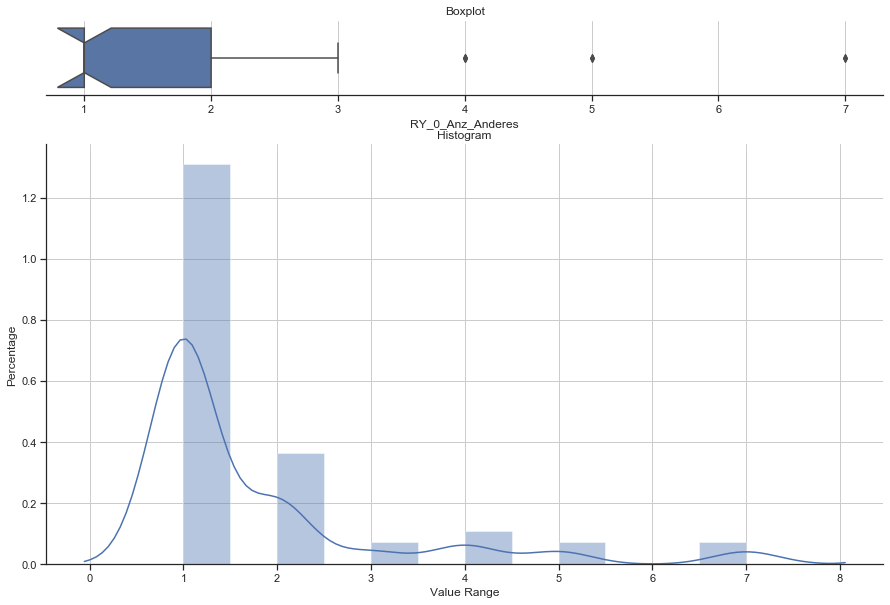

RY_1_Anz_Anderes


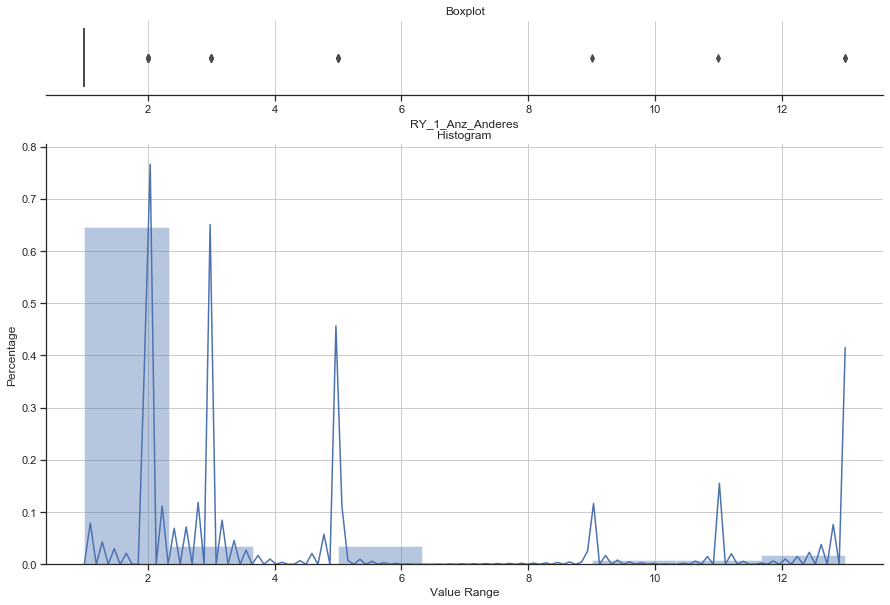

RY_2_Anz_Anderes


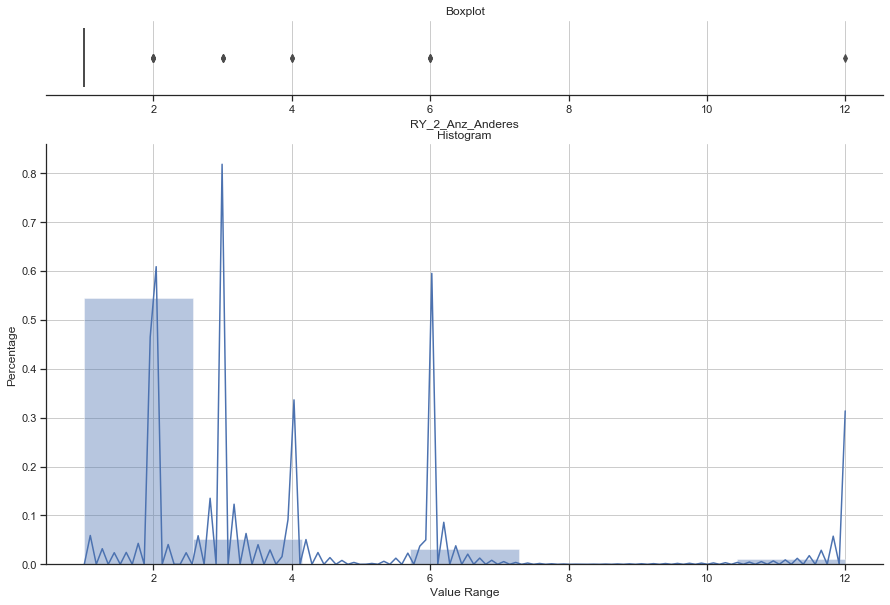

RY_3_Anz_Anderes


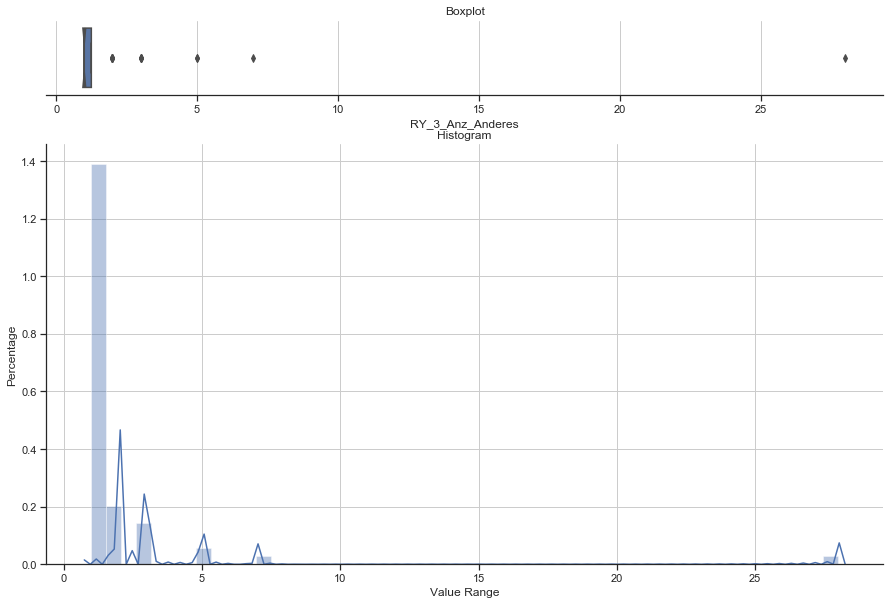

Letzter_Kontakt_Delta_Anderes


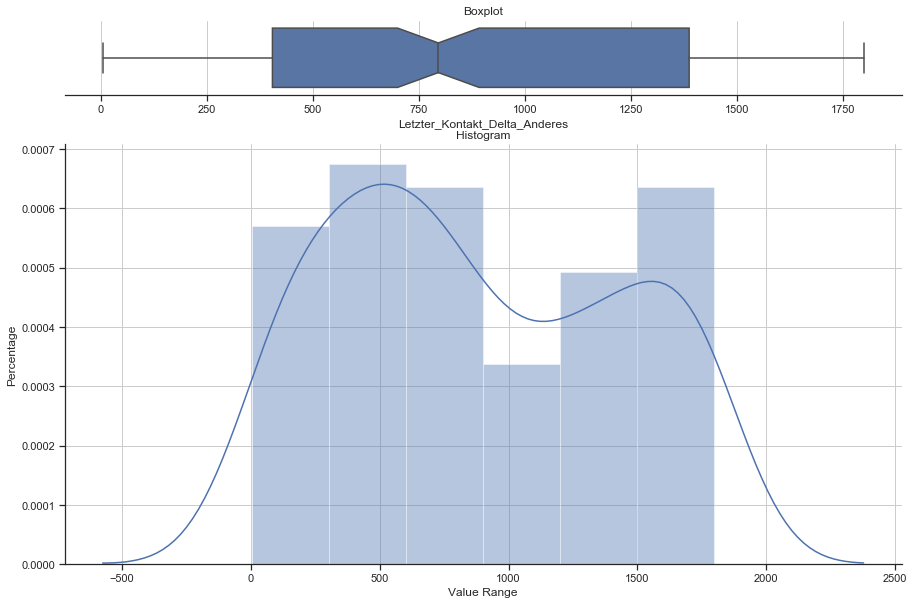

Letzter_Kontakt_Delta_Besprechung


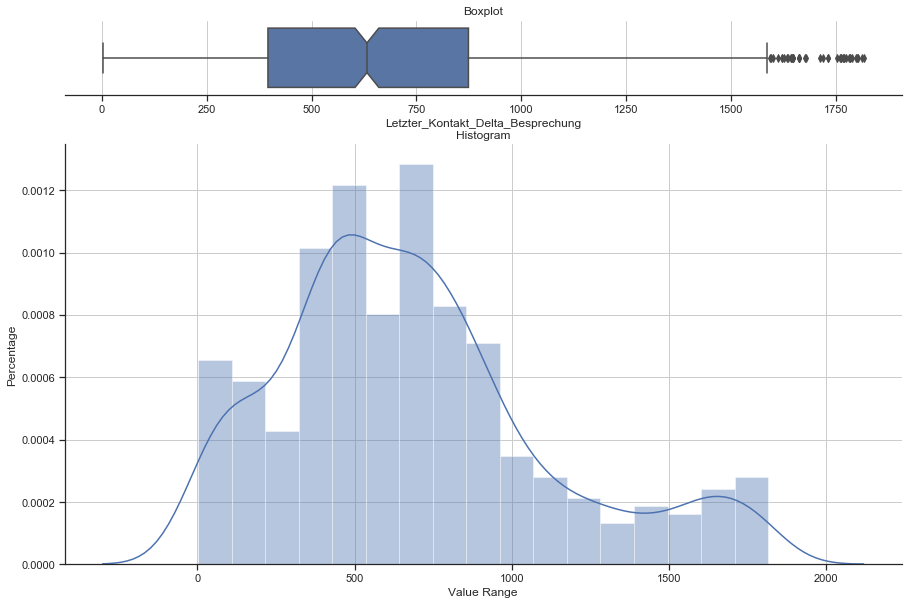

Letzter_Kontakt_Delta_Besuch


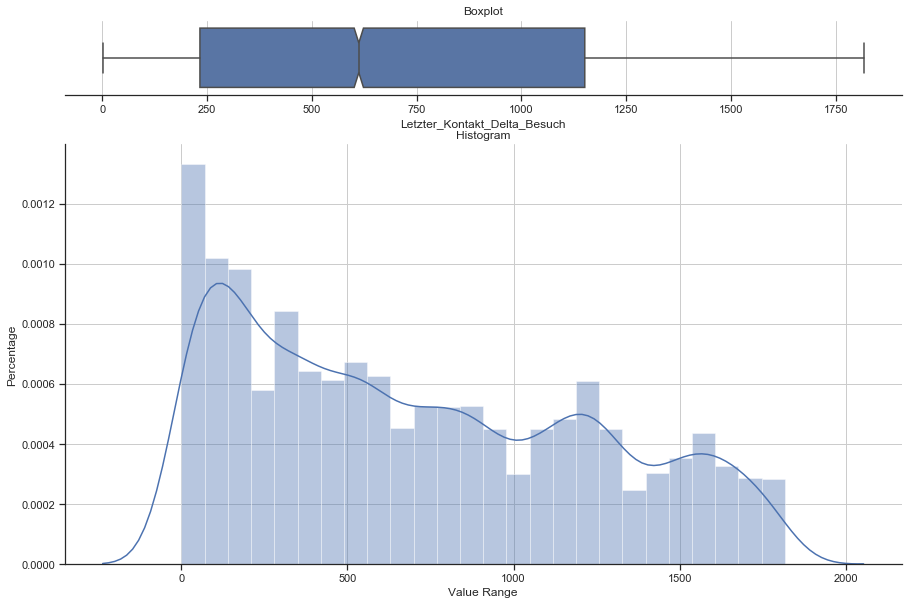

Letzter_Kontakt_Delta_Brief_Dankeskarte


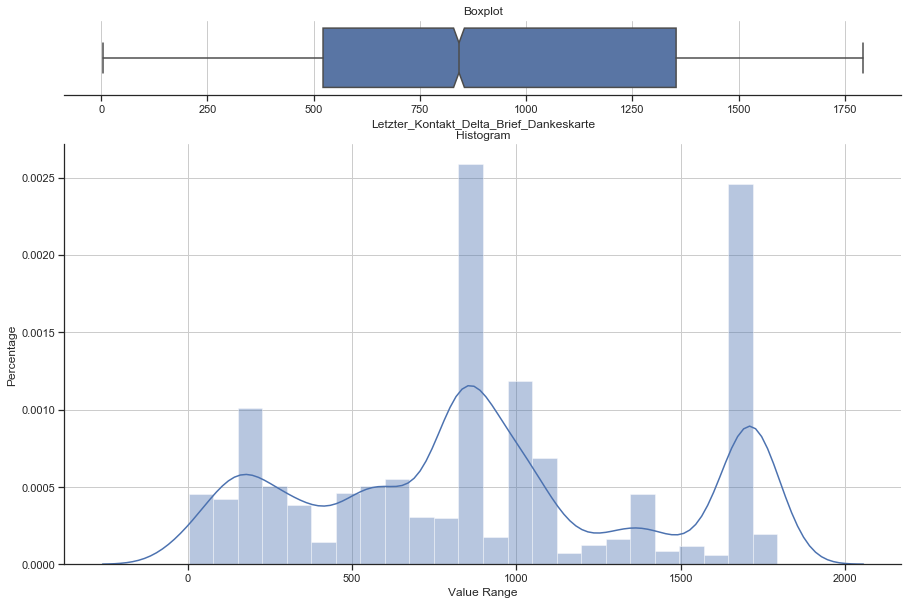

Letzter_Kontakt_Delta_E-Mail


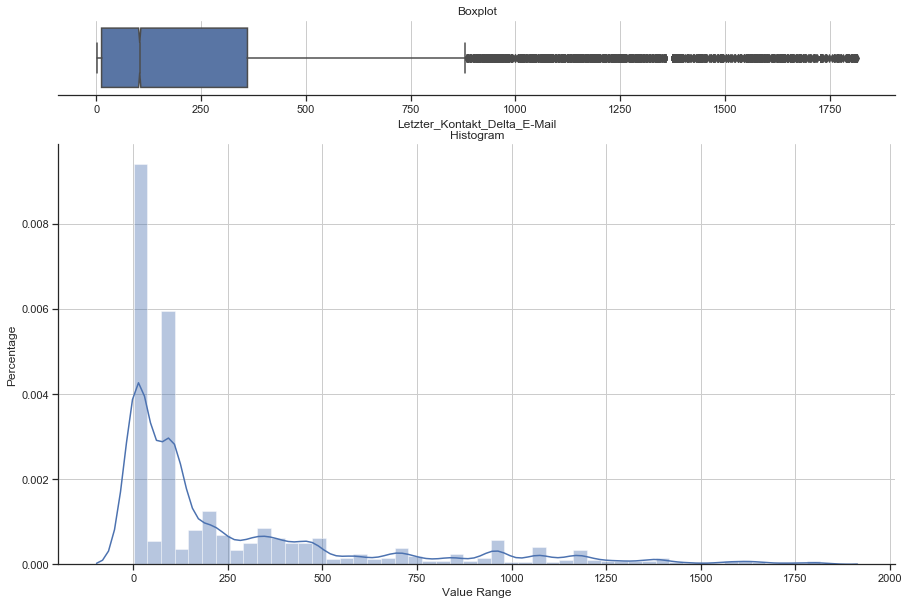

Letzter_Kontakt_Delta_Event_Veranstaltung


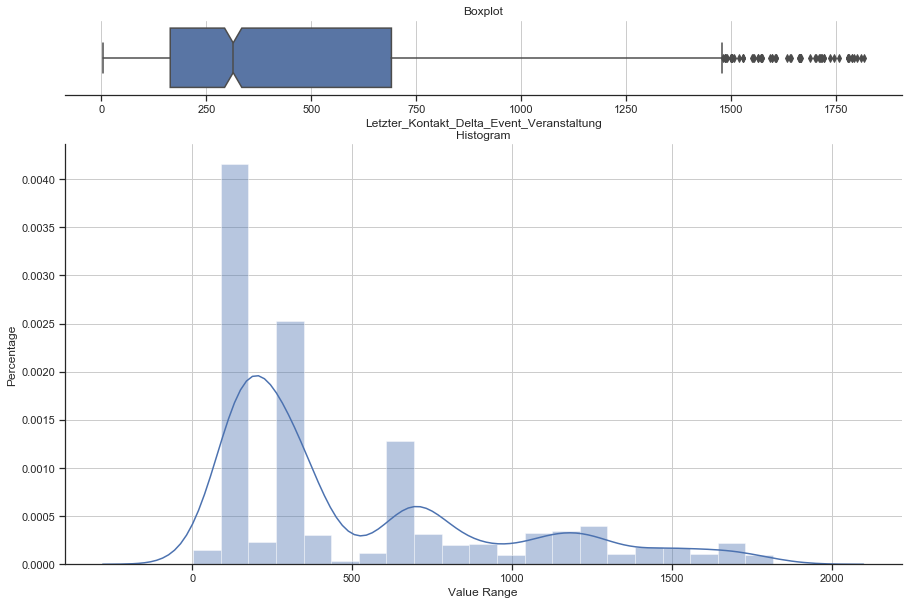

Letzter_Kontakt_Delta_Telefon


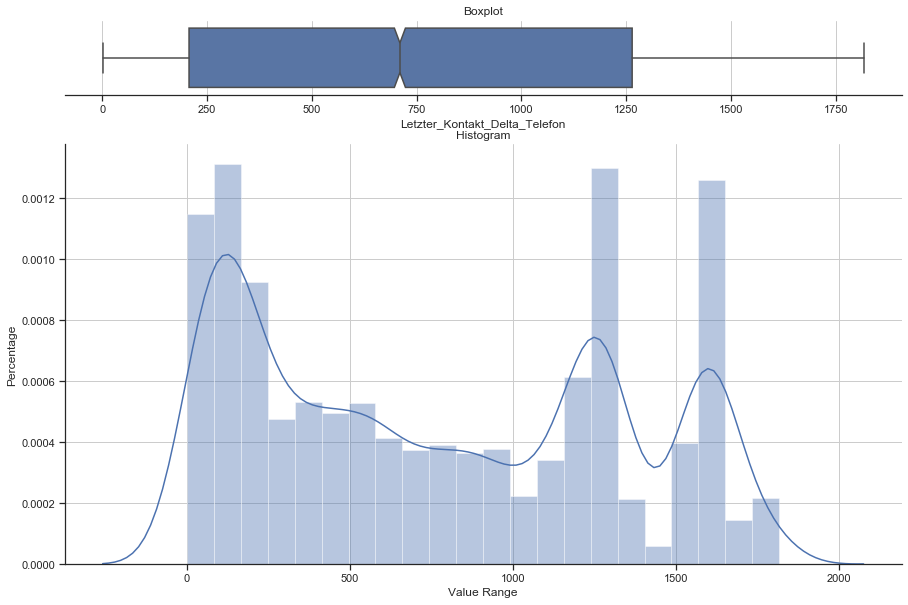

Letzter_Kontakt_Delta_global


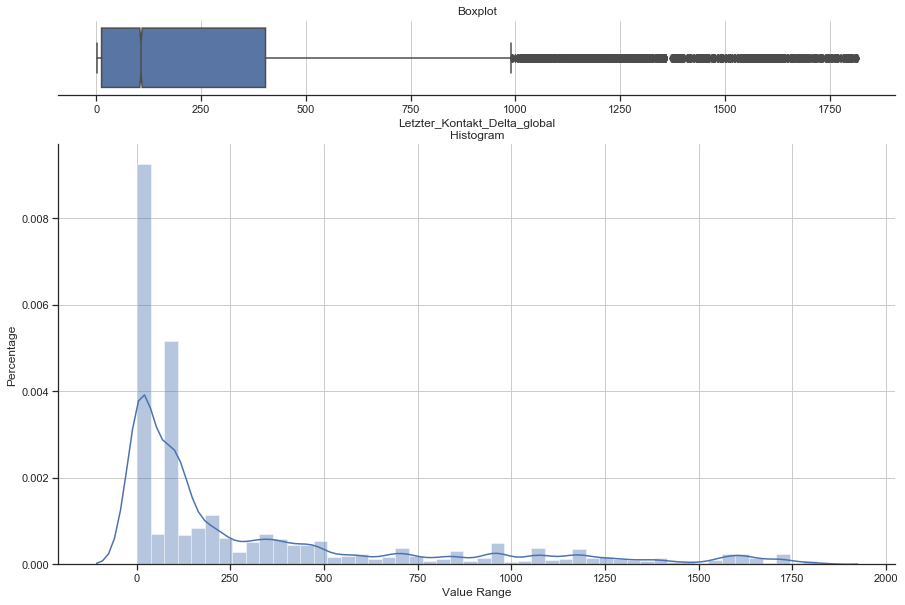

In [18]:
lazy_bxplt_hstgrm(crm_train_df)

In [ ]:
crm_train_df.iloc[:,28:].describe()

In [ ]:
2181/365